In [188]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib
matplotlib.use('TkAgg')
from define import qcode as qc
from define.submission import Submission
from define.load import LoadSub
from define.fnames import PhysicalChannel
from define.chanreps import ConvertRepresentations
from define.chandefs import FixedRotation
from define import globalvars as gv
from scipy.sparse.linalg import eigs

In [2]:
def ProcessToChi(process):
    chi = np.zeros_like(process, dtype = np.complex128)
    q = 0
    for p in process:
        chi[q] = ConvertRepresentations(p, "process", "chi")
        q+=1
    return chi
# def ProcessToChi(process):
#     return np.array(list(map(lambda P: ConvertRepresentations(P, "process", "chi"), process)), dtype=np.complex128)

In [211]:
def Kron(*mats):
    """
    Kronecker product of a list of matrices from end to start.
    """
    if(len(mats) == 0):
        return 0
    res = 1
    for i in range(len(mats)):
        res = np.kron(res, mats[i])
    return res

In [4]:
def GetPauliPhase(qcode):
    nstabs = 2**(qcode.N - qcode.K)
    ops_LST = qcode.PauliOperatorsLST
    lookup = qcode.lookup.astype(int)
    phases = np.ones(len(ops_LST), dtype = np.complex128)
    prods = np.zeros(((len(ops_LST),qcode.N)),dtype=np.int64)
    for op_index in range(len(ops_LST)):
        t_op = np.mod(op_index, nstabs)
        # print("t_op : {} m1 : {} m2: {}".format(t_op, lookup[:,2:][t_op], ops_LST[op_index]))
        (prods[op_index], phases[op_index]) = qc.PauliProduct(lookup[:,2:][t_op], ops_LST[op_index])
    return prods, phases

In [5]:
def LogicalInfidelity(chi, qcode, phases):
    nstabs = 2**(qcode.N - qcode.K)
    log_fid = 0
    lexicographic = np.sum(np.power(4, np.arange(qcode.N))[::-1] * qcode.Paulis_correctable, axis=1)
    for t in range(nstabs):
        for j in range(t*nstabs,(t+1)*nstabs):
            indj = qcode.PauliCorrectableIndices[j]
            lindj = lexicographic[j]
            for k in range(t*nstabs,(t+1)*nstabs):
                indk = qcode.PauliCorrectableIndices[k]
                lindk = lexicographic[k]
                term = chi[lindj,lindk] * phases[indj] * np.conj(phases[indk])
                log_fid += term
    return (1 - np.real(log_fid))

In [6]:
def ImpactOfRC(nqchi, nqchi_RC, qcode, phases):
    # Logical infidelity for the non RC channel.
    loginfid_noRC = LogicalInfidelity(nqchi, qcode, phases)
    # Logical infidelity with RC.
    loginfid_RC = LogicalInfidelity(nqchi_RC, qcode, phases)
    impact = loginfid_noRC/loginfid_RC
    return (loginfid_noRC, loginfid_RC, impact)

In [205]:
# Load the elements of the code.
qcode = qc.QuantumErrorCorrectingCode("7qc_cyclic")
qc.Load(qcode)
nstabs = 2**(qcode.N - qcode.K)
(prods, phases) = GetPauliPhase(qcode)

In [212]:
# Load the elements of the (non RC and RC) channels.
# submit = Submission()
# exists = LoadSub(submit, "degradation", 1, 0)
# process = np.reshape(np.load(PhysicalChannel(submit, submit.noiserates[0, :])), [7, 4, 4])
params = [0.78539816339745, 1.5707963267949, 0.66**10]
# params = [np.pi/4, 0, 0.66**10] # Hadamard axis
kraussq = FixedRotation(params)
processq = ConvertRepresentations(kraussq, "krauss", "process")
print("Process for one qubit : {}".format(processq))
print("1 qubit infidelity : {} ".format(1 - np.trace(processq)/4))
for j in range(0,7):
    process[j,:,:] = processq
chi = ProcessToChi(process)
nqchi = Kron(*chi)
nqchi_RC = np.diag(np.diag(nqchi))

Process for one qubit : [[ 1.00000000e+00 -3.46944695e-18  0.00000000e+00  0.00000000e+00]
 [-3.46944695e-18  9.95240704e-01 -7.72640347e-02  5.93819074e-02]
 [ 0.00000000e+00  7.64505136e-02  9.96947307e-01  1.58551404e-02]
 [ 0.00000000e+00 -6.04256648e-02 -1.12399038e-02  9.98109415e-01]]
1 qubit infidelity : 0.0024256436297019073 


In [213]:
(perf_RC, perf_nonRC, impact) = ImpactOfRC(nqchi, nqchi_RC, qcode, phases)
print("non RC performance: {}\nRC performance: {}\nImpact: nonRC/RC = {}.".format(perf_nonRC, perf_RC, impact))

non RC performance: 8.079262200644255e-05
RC performance: 0.00010172947515230124
Impact: nonRC/RC = 1.2591431324532227.


In [122]:
def PLog(mat):
    """
    Take a log where n0.00017330230190712453
Minimum delta for level 1: 1.0000017494466467, is achion-posvitive entries are set to 1 before applying the log function, so that they can be set to zero in the result.
    """
    cutoff = 1E-5
    mat = np.abs(mat)
    mat[mat <= cutoff] = cutoff
    return np.log10(mat)

In [118]:
def ChopSmallOffDiag(mat, thresh = 1e-3):
    mat_chopped = np.zeros_like(mat)
    for i in range(mat.shape[0]):
        for j in range(i+1, mat.shape[1]):
            if(np.abs(mat[i,j]) > thresh):
                mat_chopped[i,j] = mat[i,j]
            if(np.abs(mat[j,i]) > thresh):
                mat_chopped[j,i] = mat[j,i]
    for i in range(mat.shape[0]):
        mat_chopped[i,i] = mat[i,i]
    for i in range(mat.shape[0]):
        for j in range(i+1, mat.shape[1]):
            if(np.abs(mat_chopped[i,j])**2 > mat_chopped[i,i]*mat_chopped[j,j]):
                if(mat_chopped[i,i] <=0 and mat_chopped[j,j] <=0):
                    mat_chopped[i,j] = 0
                    mat_chopped[j,i] = 0
                elif(mat_chopped[j,j] > 0):
                    mat_chopped[i,i] = (np.abs(mat_chopped[i,j])**2)/mat_chopped[j,j]
                else:
                    mat_chopped[j,j] = (np.abs(mat_chopped[i,j])**2)/mat_chopped[i,i]
    mat_chopped /= np.trace(mat_chopped)
    for i in range(mat.shape[0]):
        for j in range(i+1, mat.shape[1]):
            if(np.abs(mat_chopped[i,j])**2 > mat_chopped[i,i]*mat_chopped[j,j]):
                print("Violation at i: {} j: {} off-diag : {} diagi : {} diagj : {}".format(i,j,np.abs(mat_chopped[i,j])**2 , mat_chopped[i,i], mat_chopped[j,j]))
    return mat_chopped

In [12]:
def ConstructLeadingChi(chi, k = 1):
    eigs,eigvecs = np.linalg.eig(chi)
    order_of_eigs = np.argsort(np.abs(eigs))[::-1]
#     print("Eigs : {} , order of eigs : {}".format(eigs, order_of_eigs))
    eigs = eigs[order_of_eigs]
    eigvecs = eigvecs[:,order_of_eigs]
    eigs[k+1:] = 0
    chi_reconstructed = np.dot(np.dot(eigvecs,np.diag(eigs)), np.linalg.inv(eigvecs))
    return chi_reconstructed

In [175]:
(perf_RC, perf_nonRC, impact) = ImpactOfRC(nqchi_chopped, nqchi_RC_chopped, qcode, phases)
print("non RC performance: {}\nRC performance: {}\nImpact: nonRC/RC = {}.".format(perf_nonRC, perf_RC, impact))

non RC performance: 0.00013103084872967408
RC performance: 5.064408079680227e-05
Impact: nonRC/RC = 0.38650501990782793.


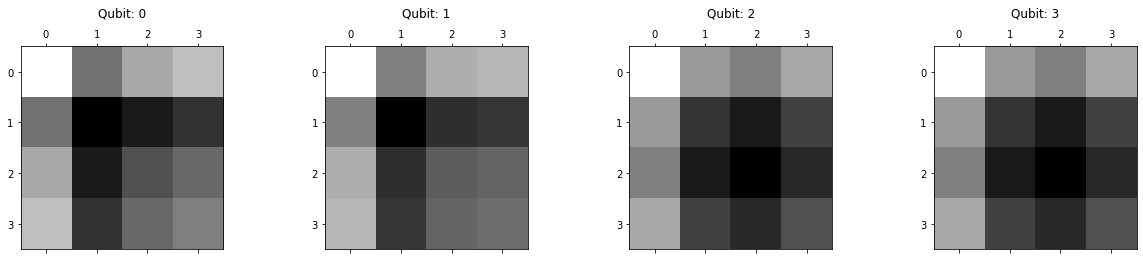

In [186]:
figs, axs = plt.subplots(1, 4, figsize=(20,20))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
for q in range(4):
    axs[q].set_title("Qubit: %d" % (q), pad=20)
#     axs[q].matshow(PLog(ProcessToChi(process[q, np.newaxis, :, :])[0]), cmap="gray")
    axs[q].matshow(PLog(chi[q]), cmap="gray")
    
    # plt.savefig("matrix_plot.png", format="png", dpi=300)


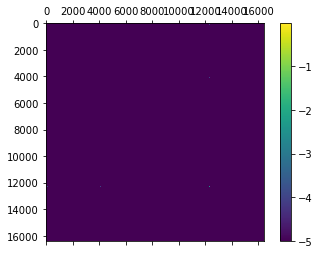

In [187]:
# plt.matshow(, cmap="gray")

figure = plt.figure()
axes = figure.add_subplot(111)
  
# using the matshow() function 
caxes = axes.matshow(PLog(np.abs(nqchi)))
figure.colorbar(caxes)
plt.savefig("matrix_plot.png", format="png", dpi=300)
# plt.show()



In [101]:
def checkChiValidity(chi,n=None):
    if n is None:
        e,_ = eigs(chi)
    else:
        e,_ = eigs(chi, k=n)
    atol = 1e-10
    e[np.abs(e) < atol] = 0
    print("trace of chi = {}".format(np.sum(e)))
    print("eigenvalues : {}".format(e))
    print("Positivity of chi = {}".format(np.all(np.real(e)>=0)))
    return e

In [119]:
nqchi_chopped = ChopSmallOffDiag(nqchi[:256,:256])
e = checkChiValidity(nqchi_chopped)

trace of chi = (1.0003278538245297-1.5190442618584635e-17j)
eigenvalues : [ 9.99975074e-01-1.50132483e-17j -3.05665104e-03+1.69420913e-18j
  2.46501246e-03-9.43590246e-19j -9.16953110e-04-4.36322783e-19j
  9.79950824e-04-2.31619488e-19j  8.81420469e-04-2.59870938e-19j]
Positivity of chi = False


trace of chi = (0.9977739205941021-5.1398161041745287e-17j)
eigenvalues : [ 0.99949546-5.16428299e-17j -0.01470203+1.32753562e-19j
  0.0053084 +4.99245456e-19j  0.00302576-2.14287341e-19j
  0.00291552-7.52455889e-20j  0.00173081-9.77972651e-20j]
Positivity of chi = False


In [87]:
print(np.diag(nqchi))

[0.98115423+0.j 0.        +0.j 0.        +0.j ... 0.        +0.j
 0.        +0.j 0.        +0.j]


In [94]:
chi[3]

array([[ 9.96493248e-01+0.j        ,  0.00000000e+00+0.00169108j,
         1.08420217e-19-0.01929766j,  0.00000000e+00+0.05584976j],
       [ 0.00000000e+00-0.00169108j,  2.86979940e-06+0.j        ,
        -3.27486441e-05+0.j        ,  9.47785076e-05+0.j        ],
       [ 1.08420217e-19+0.01929766j, -3.27486441e-05+0.j        ,
         3.73710335e-04+0.j        , -1.08156257e-03+0.j        ],
       [ 0.00000000e+00-0.05584976j,  9.47785076e-05+0.j        ,
        -1.08156257e-03+0.j        ,  3.13017193e-03+0.j        ]])

In [110]:
# Status : chopoffdiagsmall does not return pos matrix still. look into restroing positivity after truncation

In [125]:
ConvertRepresentations(chi[0],"chi","choi")

array([[0.5+0.j, 0. +0.j, 0. +0.j, 0.5+0.j],
       [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j],
       [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j],
       [0.5+0.j, 0. +0.j, 0. +0.j, 0.5+0.j]])

In [126]:
chi[0]

array([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]])